# BUILDING IMAGE CLASSIFIER USING PRETRAINED XCEPTION MODEL
_**Building an Image Classifier using a Pretrained Xception Model on TensorFlow Flower Dataset.**_

In [38]:
# Imports required modules and methods

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Loading & Analyzing Data

In [2]:
# As this dataset does not provide a seperate test dataset, full training set gets further splitted
# into test [first 10%], validation [next 15%] and train [remaining 75%] dataset.

(test_set_raw, val_set_raw, train_set_raw), info = tfds.load(
    "tf_flowers",                                              # Name of the dataset
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],    # Split of the data to load
    as_supervised=True,                                        # To return both features and labels
    with_info=True                                             # Also to return dataset information
)

2025-02-19 19:57:42.963408: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# [OPTIONAL] Prints information related to train set
print(info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/home/pradip/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


In [ ]:
# Extract useful information about the dataset

# dataset_size = info.splits["train"].num_examples    # Number of instances
#class_names = info.features["label"].names          # Names of classes that the flowers belong to
#n_classes = len(class_names)                        # Count of different types of flowers

In [8]:
# Prints the labels [the types of flower images the dataset has]
print(info.features["label"].names)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


2025-02-19 21:04:40.243941: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-02-19 21:04:40.330662: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-02-19 21:04:40.334719: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


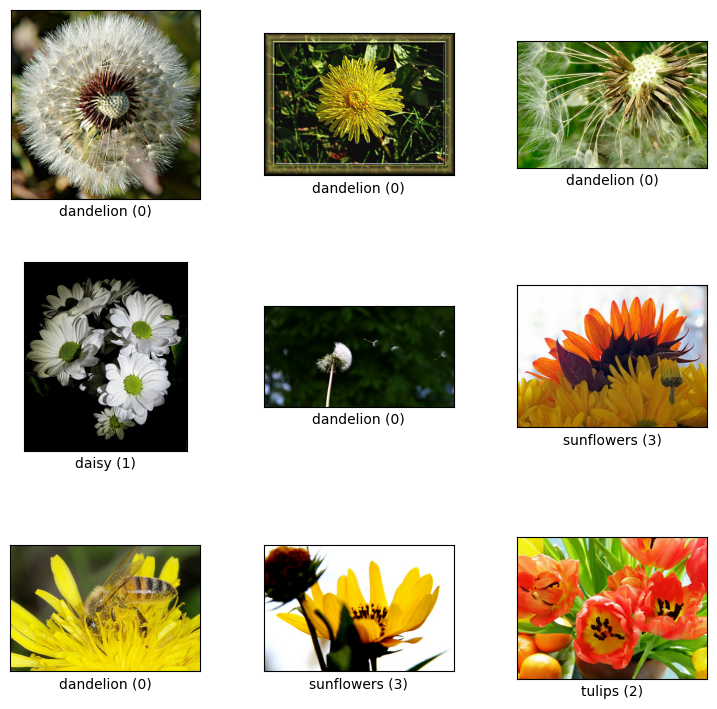

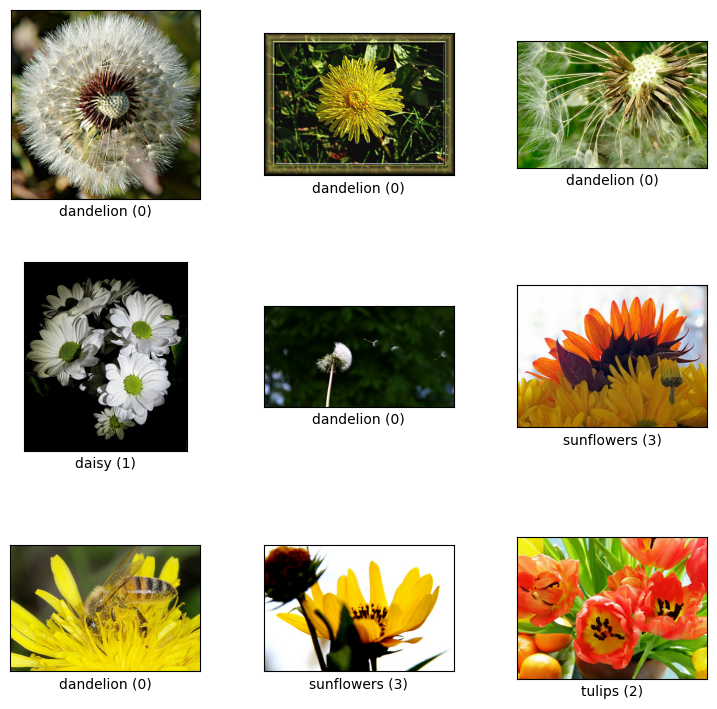

In [9]:
# [OPTIONAL] Visualize few of the images (and labels) from train set.

tfds.show_examples(train_set_raw, info)

## Data Preparation

Primary steps to prepare datasets for `Xception` are as follows.

1. As training instances required to be of the same size during batch processing, image resizing is done over a `Resizing` layer.

2. The function `tf.keras.applications.xception.preprocess_input()` needs to be called to preprocess the images appropriately for the `Xception` model.

3. _Shuffling_ and _prefetching_ are added to the dataset.

**Resizing input images**

In [10]:
# Sets the global random seed for prerations that rely on a random seed
tf.random.set_seed(42)

# Sets the batch size
batch_size = 32

# Configures a preprocessing layers for image resizing and scaling
preprocess = tf.keras.Sequential([
    # Resizes input image to a target height and width without aspect ratio distortion
    tf.keras.layers.Resizing(height=150, width=150, crop_to_aspect_ratio=True),

    # Pixel values in the range [0, 255] are scaled between -1 and 1, sample-wise
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

In [11]:
# Transforms (resizes) train set by passing it through the preprocessing layers
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))

# Then shuffles instances and enables prefetching for effective batch processing [applicable only for train set]
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

In [12]:
# Similarly, validation and test set also get transformed by passing them through the preprocessing layers

val_set = val_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size).prefetch(1)

test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size).prefetch(1)

Now each batch contains 32 images, all of them 150 × 150 pixels, with pixel values ranging from –1 to 1.

## Modeling

**Loads `Xception` pretrained model**

In [15]:
tf.random.set_seed(42)

# Loads Xception model pretrained over imagenet dataset except top layers (3 fully-connected layers 
# including global average pooling and dense output layer] at the top of the network

# NOTE: Downloading Xception weights may take several minutes to complete for the first time
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

In [16]:
# [OPTIONAL] Gets total number of parameters and layers of the base model for reference

print("Count of parameters:", base_model.count_params())
print("Count of layers [except top ones]:", len(base_model.layers))


Count of parameters: 20861480
Count of layers [except top ones]: 132


**Adds task specific [in this case it is flower classification task] top layers.**

In [17]:
# Adds an global average pooling layer on top of the base model
avg_pool = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Adds a dense layer as output
output = tf.keras.layers.Dense(info.features["label"].num_classes, activation="softmax")(avg_pool)

# Assembles the model specififying input and output
model = tf.keras.Model(inputs=base_model.input, outputs=output)

**Partially trains [warm start] only the newly added top layers**

In [18]:
# Locks layers of the base model to prevent its weights from being changed during warm start
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Trains the model over just an epoch (with relatively higher learning rate) to first set the weights 
# of the newly added top layers towards their near optimal values

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# NOTE: Training the following model may take several minutes to complete if run on CPU
history = model.fit(train_set, validation_data=val_set, epochs=1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 66s 714ms/step - accuracy: 0.6600 - loss: 1.6581 - val_accuracy: 0.7768 - val_loss: 1.7926


After the training of added layers the validation accuracy of the pretrained model was observed to be **77.68%**.

In [ ]:
# Now, evaluates model's performance on test dataset
model_test_performance = model.evaluate(test_set)

print("Test Performance [Accuracy]: {:.1f}%".format(model_test_performance[1] * 100))


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 553ms/step - accuracy: 0.8282 - loss: 1.2804


[1.2390717267990112, 0.8283378481864929]

After training the 2 newly added layers at the top, that the model's test accuracy  **82.83%**.

In [21]:
# [OPTIONAL] Saves the above model for later references.
# NOTE: Make sure the folder "models" exists under the current working directory

model.save("./models/my_xception_model_with_only_added_top_layers_trained.keras")

**Fine-tuning: Continuing training further over larger number of top layers**

In [ ]:
# [OPTIONAL] Lists [in 4-column format] all layers of the model to approximate layers to fine-tune

for row_idx in range(34):  # 34 rows will be required to show all layers in 4-column format
    # The loop below prints all layers in a row (by calculating layer id offset)
    for layer_idx in range(row_idx, row_idx+(34*3)+1, 34):  # range(start, stop[, step])
        if (layer_idx < 134):
            print(f"{layer_idx:3}: {model.layers[layer_idx].name:22}", end="")
    print() # Just for linebreak between rows

  0: input_layer_1          34: batch_normalization_2  68: block8_sepconv1_bn    102: block11_sepconv3_act  
  1: block1_conv1           35: add_2                  69: block8_sepconv2_act   103: block11_sepconv3      
  2: block1_conv1_bn        36: block5_sepconv1_act    70: block8_sepconv2       104: block11_sepconv3_bn   
  3: block1_conv1_act       37: block5_sepconv1        71: block8_sepconv2_bn    105: add_9                 
  4: block1_conv2           38: block5_sepconv1_bn     72: block8_sepconv3_act   106: block12_sepconv1_act  
  5: block1_conv2_bn        39: block5_sepconv2_act    73: block8_sepconv3       107: block12_sepconv1      
  6: block1_conv2_act       40: block5_sepconv2        74: block8_sepconv3_bn    108: block12_sepconv1_bn   
  7: block2_sepconv1        41: block5_sepconv2_bn     75: add_6                 109: block12_sepconv2_act  
  8: block2_sepconv1_bn     42: block5_sepconv3_act    76: block9_sepconv1_act   110: block12_sepconv2      
  9: block2_sepconv

In [28]:
# Unlocks all the layers in last 4 blocks [starting from layer 96 thorugh output layer] to fine-tune the model
for layer in base_model.layers[96:]:
    layer.trainable = True

In [36]:
# Compiles the model with optimizer initialized with standard learning rate
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              metrics=["accuracy"])

# Fits the model 
# NOTE: Training the following model may take several minutes to complete if run on CPU
history = model.fit(train_set, 
                    validation_data=val_set, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("./model_weights/my_xception_model.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
                    ],
                    epochs=15
                    )

Epoch 1/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8210 - loss: 0.5271 - val_accuracy: 0.8348 - val_loss: 0.9268
Epoch 2/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9610 - loss: 0.1292 - val_accuracy: 0.8584 - val_loss: 0.6546
Epoch 3/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9838 - loss: 0.0549 - val_accuracy: 0.8748 - val_loss: 0.5758
Epoch 4/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9941 - loss: 0.0184 - val_accuracy: 0.8675 - val_loss: 0.5547
Epoch 5/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9966 - loss: 0.0155 - val_accuracy: 0.8820 - val_loss: 0.5084
Epoch 6/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.8730 - val_loss: 0.5724
Epoch 7/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9935 - loss: 0.0179 - val_accuracy: 0.8838 - val_loss: 0.5227
Epoch 8/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9965 - loss: 0.0093 - val_accuracy: 0.8784 - val_loss:

In [37]:
# [OPTIONAL] Saves the above model for later references.
# NOTE: Make sure the folder "models" exists under the current working directory

model.save("./models/my_xception_model_with_top_layers_fine-tuned.keras")

### Performance Analysis
Visualizes the learning progress and finally evaluates model's performance on test set

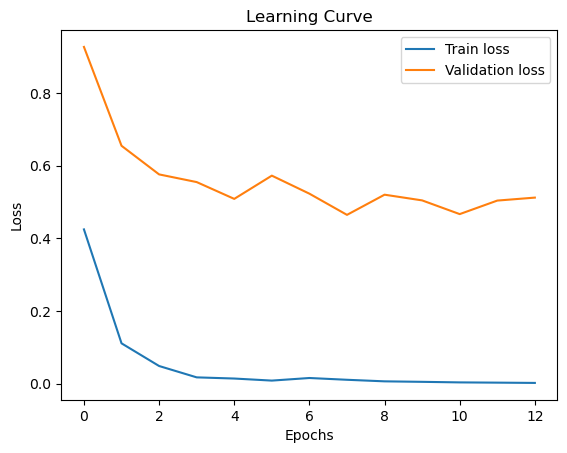

In [39]:
# Plots losses over training iterations [also know as learning curve] of the above model

plt.plot(history.history["loss"], label="Train loss")            # Plots training losses
plt.plot(history.history["val_loss"], label="Validation loss")   # Plots validation losses
plt.xlabel("Epochs")                                             # Plots label for x-axis
plt.ylabel("Loss")                                               # Plots label for y-axis
plt.legend()                                                     # Shows legends
plt.title("Learning Curve")                                      # Prints plot title

plt.show()    

In [40]:
# Now, model's performance on test dataset is evaluted below.
model_test_performance = model.evaluate(test_set)

print("Test Performance [Accuracy]: {:.1f}%".format(model_test_performance[1] * 100))


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 537ms/step - accuracy: 0.9141 - loss: 0.3130
Test Performance [Accuracy]: 90.5%


**Observations:**

- Model training was stopped after **12th** epochs considering no improvement over previous best performance for specified number of training iterations (epochs).

- The best validation performance was observed during **7th** ecoch and the model started overfitting beyond that.

- The test set performance by the best model has reached **90.5%** from **82.83%** after fine-tuning the last few blocks.